In [38]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
# import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Dealing with Data
https://www.kaggle.com/datasets/praveengovi/coronahack-chest-xraydataset?resource=download

In [39]:
import csv
label_dir = '/home/sophia/Documents/VSCode/ESE5460/proj/archive/Chest_xray_Corona_Metadata.csv'
with open(label_dir) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter= ',')
    next(csv_reader)
    
    train_label = []
    train_filename = []
    test_label = []
    test_filename = []
    
    # 0 - normal; 1 - Pnemonia
    
    for row in csv_reader:
        if 'jpeg' in row[1]:
            if row[3] == 'TRAIN':
                train_filename.append(row[1])
                if row[2] == 'Normal':
                    train_label.append(torch.tensor([0]))
                else:
                    train_label.append(torch.tensor([1]))
            else:
                test_filename.append(row[1])
                if row[2] == 'Normal':
                    test_label.append(torch.tensor([0]))
                else:
                    test_label.append(torch.tensor([1]))

The following code takes about a minute to run
> but it does help guarantee the label matches the correct image, and we have the right number of images and labels

In [76]:
from PIL import Image
import glob
train_dir = '/home/sophia/Documents/VSCode/ESE5460/proj/archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/*.jpeg' 
train_img_list = []
train_img_file= []
for name in train_filename:
    for filename in glob.glob(train_dir):
        
        if name == filename[117:]:
            train_img_file.append(filename[117:]) # these numbers depend on my traindir length that I'm getting rid of
            im = Image.open(filename)
            train_img_list.append(im)
    
test_dir = '/home/sophia/Documents/VSCode/ESE5460/proj/archive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test/*.jpeg'
test_img_list = []
test_img_file = []
for name in test_filename:
    for filename in glob.glob(test_dir):
        
        if name == filename[116:]:
            test_img_file.append(filename[116:])
            im = Image.open(filename)
            test_img_list.append(im)


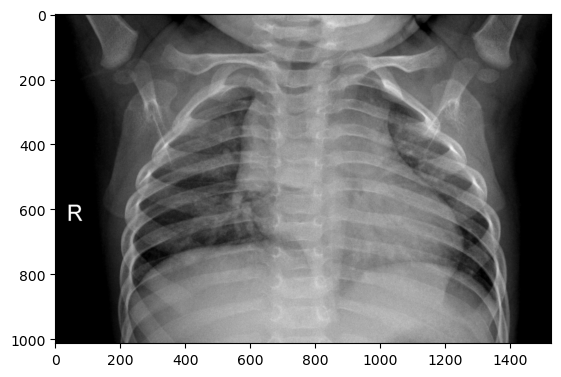

In [77]:
plt.imshow(train_img_list[0], cmap = 'gray')
plt.show()

In [111]:
class XRayDataset(Dataset):
    def __init__(self, labels, img, transforms):
        self.labels = labels
        self.img = img
        self.transforms = transforms
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, ind):
        image = self.img[ind]
        image = self.transforms(image)
        label = self.labels[ind]
        
        # sample = {'xray': image, 'label': label}
        
        return image, label
transform_reform = transforms.Compose([
                            transforms.Grayscale(3),
                            transforms.ToTensor(),
                            transforms.Resize((224,224))
                            
                            ])
traindataset = XRayDataset(labels=train_label, img = train_img_list, transforms=transform_reform)
testdataset = XRayDataset(labels=test_label, img = test_img_list, transforms=transform_reform)

traindataloader = DataLoader(traindataset, batch_size = 16, shuffle = True)
testdataloader = DataLoader(testdataset, batch_size = 16, shuffle = True)


In [112]:
# for i in range(len(testdataset)):
#     sample = testdataset[i]
#     print(i, sample['xray'].size(), sample['label'].size())
    
#     if i==30:
#         break

In [113]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding = 0),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU()
                            )
        self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding = 1),
                            nn.BatchNorm2d(out_channels)
                            )
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module): # 34 layers
    def __init__(self, block, layers, num_classes = 2):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                            nn.BatchNorm2d(64),
                            nn.ReLU()
                            )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
        
        self.layer0 = self.make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self.make_layer(block, 128, layers[1], stride = 2)
        self.layer2 =  self.make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self.make_layer(block, 512, layers[3], stride = 2)

        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, planes, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0),1)
        x = self.fc(x)
        
        return x

In [114]:
def train(net, trainloader, testloader, epochs, criterion, optimizer):
    model = net.to(device)
    total_step = len(trainloader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    
    for ep in range(epochs):
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(trainloader):
            # if ep==0 and i <=5:
            #     print(i, (images, labels))
            images = images.to(device)
            labels = labels.to(device)
            
            outputs=model(images)
            loss = criterion(outputs, labels)
            
            optimizer.zero.grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size()
            correct += (predicted == labels).sum().item()
            
            if (i+1)%1000 ==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(ep+1, epochs, i+1, total_step, loss.item()))

        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)
        
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(testloader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values

            

In [115]:
num_classes = 2
epochs = 30
batch_size = 16
lr = 0.01

model = ResNet(ResBlock, [3,4,6,2]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay= 1e-4, momentum=0.9)

val_error,val_loss_values,train_error,train_loss_values = train(model, traindataloader, testdataloader, epochs, criterion, optimizer)



RuntimeError: The size of tensor a (14) must match the size of tensor b (28) at non-singleton dimension 3

: 